In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import librosa
from IPython.display import Audio
from scipy.signal import ricker, gaussian

import spleeter
from spleeter.separator import Separator
from spleeter.audio.adapter import AudioAdapter

In [2]:
song_file = "./Midnights (3am Edition)/07 Question..._.mp3"
save_folder = './song_files/'
song_name = 'Question'
separator = Separator('spleeter:4stems')
colors = ['k','g','r','b']
v_fs = 30

song, sr = librosa.load(song_file, sr=None)

t_audio = np.arange(0, len(song)/sr, 1/sr)
t_video = np.arange(0, len(song)/sr, 1/30)

audio_loader = AudioAdapter.default()
waveform, _ = audio_loader.load(song_file, sample_rate=sr)
prediction = separator.separate(waveform)

c:\Users\nrive\anaconda3\envs\Python39\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


INFO:tensorflow:Apply unet for vocals_spectrogram
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Apply unet for drums_spectrogram
INFO:tensorflow:Apply unet for bass_spectrogram
INFO:tensorflow:Apply unet for other_spectrogram
INFO:tensorflow:Restoring parameters from pretrained_models\4stems\model


In [3]:
# unpack as a list
sources = [*prediction.keys()]

# i want to create a new dictionary with keys source and values Audio(...)
audio = {}
for source in sources:
    audio[source] =  Audio(prediction[source].mean(axis=1), rate=sr)

c:\Users\nrive\anaconda3\envs\Python39\lib\site-packages\matplotlib\axes\_axes.py:7624: RuntimeWarning: divide by zero encountered in log10
  Z = 20. * np.log10(spec)


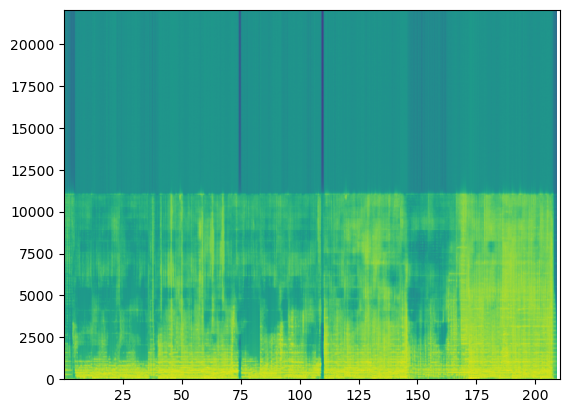

In [4]:
Sxx = {}

for source in sources:
    Sxx[source], f, t, img = plt.specgram(prediction[source].mean(axis=1), Fs=sr, NFFT=int(2*sr/v_fs), noverlap=int(sr/v_fs), mode='magnitude')

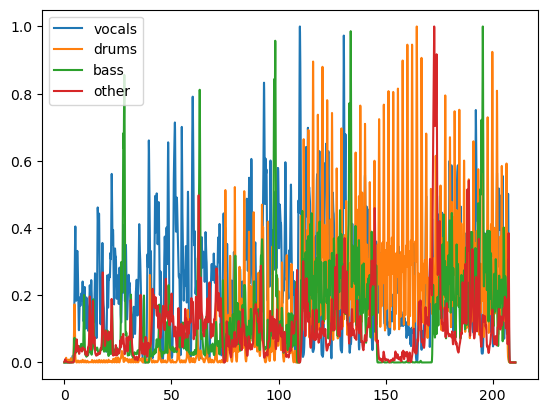

In [5]:
power = {}
filter = {}
filter = {
    'vocals' : ricker(1200, 1),
    'drums' : ricker(1200, 1),
    'bass' : ricker(1200, 1),
    'other' : ricker(1200, 1),
}

filter2 = {
    'vocals' : gaussian(600, 5),
    'drums' : gaussian(600, 5),
    'bass' : gaussian(600, 5),
    'other' : gaussian(600, 5)
}

#sources.remove('other')
sources = [*prediction.keys()]

for source in sources:
    power_temp = np.zeros(t.shape)
    for i,_ in enumerate(t):
            power_temp[i] = np.dot(Sxx[source][:,i], Sxx[source][:,i].T)

    # Each t bin is 0.03 seconds
    power_temp = np.abs(np.convolve(power_temp, filter[source], mode='same'))
    power_temp = np.convolve(power_temp, filter2[source], mode='same')

    power[source] = power_temp / power_temp.max()

for source in sources:
    plt.plot(t, power[source])

plt.legend(sources)

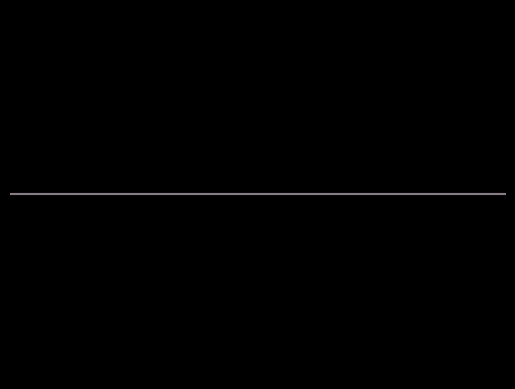

In [6]:
x = np.linspace(0,1,1000)
fig = plt.figure(facecolor='k')
ax = fig.add_subplot(111)
colors = ['midnightblue', 'maroon','darkmagenta', 'gray']

p_comp = []
for i, _ in enumerate(sources):
    pc, = ax.plot(x, np.sin(11*np.pi*x), colors[i])
    p_comp.append(pc)

plt.xlim([0, 1])
plt.ylim([-1, 1])
plt.axis('off')

pc_Hz =     [11, 7, 3, 5]
pc_phase =  [1,  1, 1, 1]

def animate(i):
    for ind, source in enumerate(sources):
        p_comp[ind].set_data(x, power[source][i]*np.sin(pc_Hz[ind]*np.pi*x - pc_phase[ind]*np.pi*i/100))

    return p_comp

ani = FuncAnimation(fig, animate, range(len(power['vocals'])), interval=100/3)
ani.save(save_folder+song_name+'_pca.mp4')